# Hamiltonian Simulation with Product Formula
<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

In quantum mechanics, a system's energy is described with a Hamiltonian operator $H$. Solving all or partial properties of the Hamiltonian of a given system constitutes a central problem in many disciplines, including condensed matter physics, computational chemistry, high-energy physics, etc. However, the degrees of freedom of a quantum system grow exponentially with its system size, which leads to the inability to effectively simulate quantum systems using classical computers - the quantum state of several hundred qubits cannot be directly stored even with all the storage resources in the world. Unlike classical computers, quantum computers perform all operations directly on the exponentially large Hilbert space, thus having a natural advantage over classical computer when simulating a quantum system. Matter of fact, designing a controlled quantum system to efficiently simulate quantum systems in nature was Feynman's original idea when he first introduced the concept of quantum computing in the 1980s:
 
> _"Nature isn't classical, dammit, and if you want to make a simulation of nature, you'd better make it quantum mechanical, and by golly it's a wonderful problem, because it doesn't look so easy."_
>
> --- "Simulating physics with computers", 1982, Richard P. Feynman [1]


The development of universal quantum computers and a series of quantum simulators has made it possible to realize Feynman's vision. Digital quantum simulation on a universal quantum computer (i.e. quantum simulation by constructing quantum circuits through quantum gates) is considered to be to have the largest potential due to its scalability and generality.

In this tutorial, we introduce Hamiltonian simulation in Paddle Quantum. It will be divided into three parts:
1. How to construct a system's Hamiltonian using `Hamiltonian` class.
2. How to create the time-evolving circuit with `construct_trotter_circuit()` function.
3. The Suzuki product formula algorithm and how to create its corresponding circuit up to arbitrary order.

## Define the system's Hamiltonian 
Before demoing how to construct a time-evolving circuit, we will first introduce to readers how to construct a `Hamiltonian` object in Paddle Quantum. Users could create a `Hamiltonian` object by specifying a list of Pauli string containing the coefficients and Pauli operators of each term. First let's consider a simple Hamiltonian:

$$
H = Z \otimes Z
\tag{1}
$$

This Hamiltonian describes a simple interaction between two qubits: when both qubits are in $|0\rangle$ or $|1\rangle$ , the energy of the system is $+1$; conversely when the two qubits are in different states, the energy of the system is $-1$.

The user could construct this Hamiltonian by:

In [1]:
from paddle_quantum.utils import Hamiltonian

h = Hamiltonian([[1, 'Z0, Z1']])
print(h)

1.0 Z0, Z1


The `Hamiltonian` class in Paddle Quantum supports automatic merging of equal terms, addition, subtraction, indexing, and splitting:

In [2]:
h = Hamiltonian([[0.5, 'Z0, Z1'], [0.5, 'Z1, Z0']], compress=True)
print(h)

1.0 Z0, Z1


In [3]:
print('h + h:', h + h)
print('h * 2:', h * 2)
print('h:', h[:])

h + h: 2.0 Z0, Z1
h * 2: 2.0 Z0, Z1
h: 1.0 Z0, Z1


The `decompose_pauli_words()` and `decompose_with_sites()` methods can decompose the Hamiltonian into more manageable forms:

In [4]:
print('Pauli words decomposition:', h.decompose_pauli_words())
print('Pauli with sites decomposition:', h.decompose_with_sites())

Pauli words decomposition: ([1.0], ['ZZ'])
Pauli with sites decomposition: ([1.0], ['ZZ'], [[0, 1]])


In addition, `construct_h_matrix()` will construct its matrix in the $Z$ Pauli basis:

In [5]:
h.construct_h_matrix()

matrix([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

## Simulate the time evolution

According to one of the fundamental axioms of quantum mechanics, the evolution of a system over time can be described by

$$
i \hbar \frac{\partial}{\partial t} | \psi \rangle = H | \psi \rangle,
\tag{2}
$$

$\hbar$ is the reduced Planck constant. This equation is the well-known Schrödinger equation. Thus, for a time independent Hamiltonian, the time evolution equation of the system can be written as

$$
|\psi(t) \rangle = U(t) | \psi (0) \rangle, ~ U(t) = e^{- i H t}.
\tag{3}
$$

Here we take the natural unit $\hbar=1$ and $U(t)$ is the time evolution operator. The idea of simulating the time evolution process with quantum circuits is to approximate this time evolution operator using the unitary transformation constructed by quantum circuits. In Paddle Quantum, we provide the `construct_trotter_circuit(circuit, Hamiltonian)` function to construct a time-evolving circuit corresponding to a Hamiltonian. Now, let us test it with the Hamiltonian we just constructed:

In [6]:
from paddle_quantum.trotter import construct_trotter_circuit
from paddle_quantum.circuit import UAnsatz

cir = UAnsatz(2)
construct_trotter_circuit(cir, h, tau=1, steps=1) 
print(cir)

--*-----------------*--
  |                 |  
--x----Rz(2.000)----x--
                       


We can see that a quantum circuit has been constructed for `h`, which can simulate the time evolution of arbitrary time length based on the input `tau`.

By calculating the matrix form of this circuit, one can see that it is identical to the time evolution operator $e^{-iHt}$. Here, we use `gate_fidelity` to calculate the fidelity between the unitary matrix of the quantum circuit and the unitary matrix of the time evolution operator. These two processes are identical when the fidelity is equal to 1. We note that a more formal definition of simulation error will be introduced at the  end of this section. For now, let's consider fidelity as the criteria of similarity between two evolution processes (unitary operators).

In [7]:
from scipy import linalg
from paddle_quantum.utils import gate_fidelity

# calculate the fidelity between e^{-iHt} and the unitary matrix of circuit
print('The fidelity is: %.3f' 
      % gate_fidelity(cir.U.numpy(), linalg.expm(-1 * 1j * h.construct_h_matrix())))

The fidelity is: 1.000


Actually, this is because any rotation associated with a tensor product of the pauli operators can be efficiently decomposed into a circuit. In this example, we could change the angle of the Rz gate to simulate any $e^{-i Z\otimes Z t}$ evolutionary operator. Does this mean that the time-evolving operator of any Pauli Hamiltonian could be perfectly simulated with a quantum circuit? Unfortunately, the answer is negative. Let us consider a slightly more complicated Hamiltonian:

$$
H = Z \otimes Z + X \otimes I + I \otimes X.
\tag{4}
$$

Similarly, let's use `construct_trotter_circuit` to construct its corresponding time-evolving circuit:

In [8]:
h_2 = Hamiltonian([[1, 'Z0, Z1'], [1, 'X0'], [1, 'X1']]) # no need to write out unit operator
cir = UAnsatz(2)
construct_trotter_circuit(cir, h_2, tau=1, steps=1)
print(cir)
print('The fidelity is: %.3f' 
      % gate_fidelity(cir.U.numpy(), linalg.expm(-1 * 1j * h_2.construct_h_matrix())))

--*-----------------*----Rx(2.000)--
  |                 |               
--x----Rz(2.000)----x----Rx(2.000)--
                                    
The fidelity is: 0.681


This time the fidelity is less than $1$, which means the circuit cannot correctly simulate the time-evolution process of the system.

The reason is that, the unitary transformation of the circuit is $e^{-iZ\otimes Z t} e^{-i (X\otimes I + I\otimes X)t}$, while the time evolution operator is $e^{-iZ\otimes Z t - i(X\otimes I + I\otimes X)t}$. And for a quantum system, $e^{A+B} \neq e^A e^B$ when $[A, B] \neq 0$. Here, since  $[X, Z] \neq 0$, the corresponding unitary transformation of the circuit is not equal to the correct time-evolution operator.

In addition to using the fidelity to describe the similarity between the quantum circuit and the time-evolving operator that one wishes to simulate, one can define the error $\epsilon$ as follows

$$
\epsilon(U) = \Vert e^{-iHt} - U \Vert,
\tag{5}
$$

where $\Vert \cdot \Vert$ denotes the mode of the largest eigen (singular) value. Such a definition better describes the deviation of the quantum state under different evolution operators and it is a more rigorous way to define the simulation time evolution error. We note that the simulation error of this form will be used repeatedly in the next section.

### Product formula and Suzuki decomposition

In 1996, Seth Lloyd showed that the error in simulating time evolution can be reduced by splitting a whole evolution time $t$ into $r$ shorter "time blocks" [2]. Consider a more general Hamiltonian of the form $H = \sum_{k=1}^{L} h_k$, where $h_k$ acts on a part of the system. By Taylor expansion, it is not difficult to find that the simulation error is a second-order term, i.e.

$$
e^{-iHt} = \prod_{k=1}^{L} e^{-i h_k t} + O(t^2).
\tag{6}
$$

Let $\tau = t/r$ and consider the evolution operator $\left(e^{-iH \tau}\right)^r$, then its error can be derived from 

$$
e^{-iHt} = \left(e^{-iH \tau}\right)^r = \left(\prod_{k=1}^{L} e^{-i h_k \tau} + O(\tau^2) \right)^r = \left(\prod_{k=1}^{L} e^{-i h_k \tau} \right)^r + O\left(\frac{t^2}{r}\right).
\tag{7}
$$

The above equation states that an arbitrarily high simulation accuracy can be achieved by splitting the whole evolution time into enough "pieces". This is the basic idea of the product formula. However, the error given in (7) is only a rough estimate. In practice, in order to estimate the depth of the quantum circuit required to achieve a certain simulation accuracy, an exact upper bound on the error needs to be further computed. In the following, we show a relatively abbreviated procedure for calculating the error upper bound and readers who are not interested in details can skip to the conclusion on the error bound in (11).

Let us note the remainder Taylor expansion of the function $f$ up to order $k$ to be $\mathcal{R}_k(f)$. And the two following statements are needed for the calculating of the error bound:

$$
\left\Vert \mathcal{R}_k \left( \prod_{k=1}^{L} \exp (-i h_k \tau) \right) \right\Vert
\leq
\mathcal{R}_k \left( \exp \left( \sum_{k=1}^{L} \vert \tau \vert \cdot \Vert h_k \Vert \right) \right),
\tag{8}
$$

$$
\vert \mathcal{R}_k(\exp (\alpha)) \vert \leq \frac{\vert \alpha \vert^{k+1}}{(k+1)!} \exp ( \vert \alpha \vert ), ~
\forall \alpha \in \mathbb{C}.
\tag{9}
$$

We omit the proofs of these two statements due to length limitations and  interested reader could refer to Section F.1 in [3]. As defined in (5), the simulation error can be written as

$$
\epsilon\left(e^{-iH\tau}, U_{\rm circuit}\right) = \left \Vert \exp\left(-i\sum_{k=1}^L h_k \tau\right) - \prod_{k=1}^{L} \exp\left(-i h_k \tau \right) \right \Vert.
\tag{10}
$$

We already know that simulation error is the reminder of the time-evolving operators' Taylor expansion to the first order. Then using (8), (9) and the triangular inequality, the upper bound on the error in (10) can be calculated as follows

$$
\begin{aligned}
\left \Vert \exp\left(-i\sum_{k=1}^L h_k \tau\right) - \prod_{k=1}^{L} \exp\left(-i h_k \tau \right) \right \Vert
=~&
\left \Vert \mathcal{R}_1 \left( \exp \left( -i \sum_{k=1}^{L} h_k \tau \right) - \prod_{k=1}^{L} \exp (-i h_k \tau) \right) \right \Vert
\\
\leq~&
\left \Vert \mathcal{R}_1 \left( \exp \left( -i \sum_{k=1}^{L} h_k \tau \right) \right) \right \Vert
+
\left \Vert \mathcal{R}_1 \left( \prod_{k=1}^{L} \exp (-i h_k \tau) \right) \right \Vert
\\
\leq~ &
\left \Vert \mathcal{R}_1 \left( \exp \left( \vert \tau \vert \cdot \left \Vert \sum_{k=1}^{L} h_k \right \Vert \right) \right) \right \Vert
+ 
\left \Vert \mathcal{R}_1 \left( \exp \sum_{k=1}^{L} \left( \vert \tau \vert \cdot \Vert h_k \Vert \right) \right) \right \Vert
\\
\leq~&
2 \mathcal{R}_1 \left( \exp ( \vert \tau \vert L \Lambda ) \right )
\\
\leq~&
 ( \vert \tau \vert L \Lambda )^2 \exp ( \vert \tau \vert L \Lambda ),
\end{aligned}
\tag{11}
$$

with $\Lambda = \max_k \Vert h_k \Vert$. Considering the complete evolution time $t = r \cdot \tau$, the error when simulating a time evolution operator of length $t$ is

$$
\begin{aligned}
\left \Vert \left ( \exp\left(-i\sum_{k=1}^L h_k \tau \right)\right)^r - \left (\prod_{k=1}^{L} \exp\left(-i h_k \tau \right) \right)^r \right \Vert
\leq ~&
r \left \Vert \exp\left(-i\sum_{k=1}^L h_k \tau\right) - \prod_{k=1}^{L} \exp\left(-i h_k \tau \right) \right \Vert
\\
=~& r (  \tau L \Lambda )^2 \exp ( \vert \tau \vert L \Lambda )
\\
=~& \frac{(  t L \Lambda )^2}{r} \exp \left( \frac{\vert t \vert L \Lambda}{r} \right).
\end{aligned}
\tag{12}
$$

Here we use the conclusion of linear accumulation of errors in quantum circuits, i.e. $\Vert U^r - V^r \Vert \leq r\Vert U - V \Vert$, and the reader who is not familiar with this conclusion can refer to Section 4.5.3 in [4]. At this point, we have calculated an upper bound on the simulation error of the product formula for a complete period of evolution time $t$, i.e., the second-order term $O(t^2/r)$ in Eq. (7). 

In fact, we can further optimize the simulation accuracy for the time-evolution operator $e^{-iH\tau}$ within each "time block" by the Suzuki decomposition. For the Hamiltonian $H = \sum_{k=1}^{L} h_k$, the Suzuki decomposition of the time evolution operator can be written as

$$
\begin{aligned}
S_1(\tau) &= \prod_{k=0}^L \exp ( -i h_k \tau),
\\
S_2(\tau) &= \prod_{k=0}^L \exp ( -i h_k \frac{\tau}{2})\prod_{k=L}^0 \exp ( -i h_k \frac{\tau}{2}),
\\
S_{2k}(\tau) &= [S_{2k - 2}(p_k\tau)]^2S_{2k - 2}\left( (1-4p_k)\tau\right)[S_{2k - 2}(p_k\tau)]^2,
\end{aligned}
\tag{13}
$$

For $k > 1, k\in\mathbb{Z}$, where $p_k = 1/(4 - 4^{1/(2k - 1)})$. The previously derived product formula actually uses only the first-order Suzuki decomposition $S_1(\tau)$ to simulate each "time block". Therefore it's also known as the first-order Suzuki product formula, or simply the first-order product formula. In some scenarios, the Suzuki product formula is also referred to as the Trotter-Suzuki decomposition. For higher-order product formulas, using similar calculations as in (10-12), it can be shown that the error bound on the error for the $2k$th order product formula is：

$$
\epsilon\left(e^{-iHt}, \left(S_{2k}(\tau)\right)^r\right)
\leq
\frac{(2L5^{k-1}\Lambda\vert t \vert)^{2k+1}}{3r^{2k}} \exp \left( \frac{2L5^{k-1}\Lambda\vert t \vert}{r} \right),
~ k > 1.
\tag{14}
$$

With the upper bound on the simulation error obtained, it is possible to further calculate the lower bound on the circuit depth required to reach a certain minimum accuracy $\epsilon$. It should be noted that the error bounds given in (12) and (14) are calculated very loosely. In recent years, many works have gone further to give tighter upper bounds [3, 5-6]. In addition, product formulas that are not based on the Suzuki decomposition have also been proposed [7].

![image.png](./figures/trotter_suzuki_circuit.png)
<div style="text-align:center">Fig 1: The circuit of Suzuki product formula </div>

### Verification of Suzuki-product formula-based time-evolving circuits using Paddle Quantum

Although the upper bound on the error of the Suzuki-product formula has been continuously optimized, in practice, the real error is often different from the theoretical upper bound, i.e., the theoretical product formula error that we can calculate now is still only a very loose upper bound [3]. Therefore, for a real physical system, we often need to calculate the real error through numerical experiments to give an empirical bound on the error. Such numerical experiments are important as they could be used to determine the circuit depth needed to simulate a certain time evolution process at a certain accuracy.

In the `construct_trotter_circuit` function, It constructs by default a circuit based on the first order product formula. Users can create simulation circuits of higher order product formulas with more time blocks by manipulating the arguments `tau`, `steps`, `order`. As the last part of this tutorial, we will demonstrate how these options work in Paddle Quantum.

Using the previous Hamiltonian:

In [9]:
print('H =', h_2)

H = 1.0 Z0, Z1
1.0 X0
1.0 X1


Here we split the evolution of $t=1$ by changing the `tau` and `steps`. (Hint: $\tau \cdot n_{\rm steps} = t$)

In [10]:
# Split the time evolution process of length t into r blocks
r = 3
t = 1
cir = UAnsatz(2)
# Construct the time evolution circuit, tau is the evolution time of each "time block", i.e. t/r
# Steps is the number of repetitions of the "time block" r
construct_trotter_circuit(cir, h_2, tau=t/r, steps=r)
print(cir)
print('The fidelity is: %.3f' 
      % gate_fidelity(cir.U.numpy(), linalg.expm(-1 * 1j * h_2.construct_h_matrix())))

--*-----------------*----Rx(0.667)----*-----------------*----Rx(0.667)----*-----------------*----Rx(0.667)--
  |                 |                 |                 |                 |                 |               
--x----Rz(0.667)----x----Rx(0.667)----x----Rz(0.667)----x----Rx(0.667)----x----Rz(0.667)----x----Rx(0.667)--
                                                                                                            
The fidelity is: 0.984


We can see that by splitting the simulation time of $t=1$ into three "time blocks", the simulation error was successfully reduced.

The error could be further reduced if we further split the evolution process into more 'pieces':

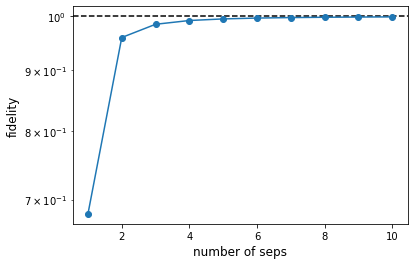

In [11]:
# Import the required packages
import matplotlib.pyplot as plt
import numpy as np

def get_fid(n_steps):
    t = 1
    cir = UAnsatz(2)
    construct_trotter_circuit(cir, h_2, tau=t/n_steps, steps=n_steps)
    return gate_fidelity(cir.U.numpy(), linalg.expm(-1 * 1j * h_2.construct_h_matrix()))
plt.axhline(1, ls='--', color='black')
plt.semilogy(np.arange(1, 11), [get_fid(r) for r in np.arange(1, 11)], 'o-')
plt.xlabel('number of steps', fontsize=12)
plt.ylabel('fidelity', fontsize=12)
plt.show()

In addition, we can reduce the simulation error by changing the order of the product formula. Currently, the `construct_trotter_circuit()` supports the Suzuki product formula of any order using the argument `order`. Let us calculate the errors of the first and second-order time-evolving circuits separately, observe their variation with $\tau$. Then compare them with the theoretical upper bounds calculated above:

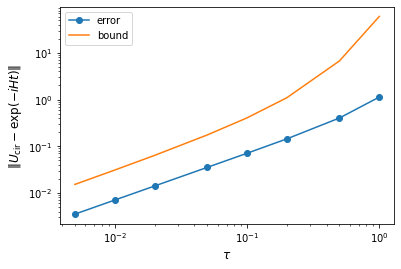

In [12]:
# Calculate the L1 spectral distance between the two unitary matrices, i.e. the error defined in (5)
def calculate_error(U1, U2):
    return np.abs(linalg.eig(U1 - U2)[0]).max()

# Encapsulates the function that calculates the error, 
# with the free parameters being the length of each time block tau and the order of the product formula
def calculate_total_error(tau, order=1):
    # An additional global phase needs to be subtracted from the error calculation because of the multiple Pauli rotating gates in the circuit
    # This global phase does not have any observable effect on the actual quantum state, but only needs to be subtracted when calculating the theoretical error
    h_2 = Hamiltonian([[1, 'Z0, Z1'], [1, 'X0'], [1, 'X1']])
    cir = UAnsatz(2)
    # A total time of 1, so steps = int(1/tau), the input tau needs to be divisible by 1
    construct_trotter_circuit(cir, h_2, tau=tau, steps=int(1/tau), order=order)
    cir_U = cir.U.numpy()
    U_evolve =  np.exp(1j) * linalg.expm(-1 * 1j * h_2.construct_h_matrix()) # Theoretical time evolution operator plus a global phase
    return calculate_error(cir_U, U_evolve)

# Different parameters tau, they need to be divisible by 1
taus = np.array([0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
errors = []

# Record the total error corresponding to different tau
for tau in taus:
    errors.append(calculate_total_error(tau))

# print the graph
plt.loglog(taus, errors, 'o-', label='error')
plt.loglog(taus, (3 * taus**2 * (1/taus) * np.exp(3 * taus)), label='bound') # The first-order error upper bound calculated according to (10)
plt.legend()
plt.xlabel(r'$\tau$', fontsize=12)
plt.ylabel(r'$\Vert U_{\rm cir} - \exp(-iHt) \Vert$', fontsize=12)
plt.show()

Next, we set `order` to 2 and calculate the error of the second-order product formula:

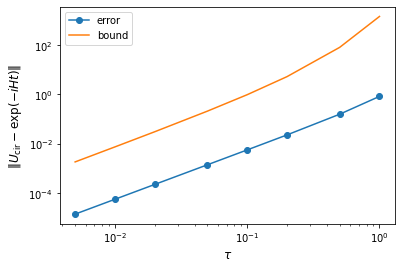

In [13]:
taus = np.array([0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
errors = []

for tau in taus:
    errors.append(calculate_total_error(tau, order=2)) # Specify the order of the Suzuki decomposition   

plt.loglog(taus, errors, 'o-', label='error')
plt.loglog(taus, (2 * taus * 3 )**3 / 3 * (1/taus) * np.exp(3 * taus), '-', label='bound') # The upper bound of the second-order error calculated according to (12)
plt.legend()
plt.xlabel(r'$\tau$', fontsize=12)
plt.ylabel(r'$\Vert U_{\rm cir} - \exp(-iHt) \Vert$', fontsize=12)
plt.show()

As expected, the actual calculated simulation errors are all smaller than their theoretical upper bounds.

## Conclusion

This tutorial introduces how to construct a time-evolving circuit with Paddle Quantum and the theoretical basis behind it, i.e.the Suzuki product formula. Users can construct arbitrary order product formula circuits with custom Hamiltonian to simulate the time evolution of different physical systems.

Quantum simulation is a vast subject and it covers a wide range of applications: the study of many-body localization, time crystals, high-temperature superconductivity, and topological order in condensed matter physics; molecular dynamics simulations and reaction simulations in quantum chemistry; field theory simulations in high-energy physics; even related applications in nuclear physics and cosmology. The Suzuki product formula and digital quantum simulations based on general-purpose quantum computers presented in this tutorial are only part of the quantum simulations. The quantum simulator not based on general-purpose quantum computers, such as analogue quantum simulations on cold atom, superconductor, ion trap and photon platforms also constitute very important topics. For readers who are interested on its applications and general background, we recommend this review [8]. 

In the subsequent tutorial [Simulating spin dynamics in one-dimensional Heisenberg chains](./SimulateHeisenberg_EN.ipynb), using the spin model in condensed matter physics as an example, we further show how to perform dynamics simulations of quantum many-body models. In the meantime, we also demonstrate how to design a customized time evolving circuit not based on the Suzuki decomposition.


---

## References

[1] Feynman, R. P. "Simulating physics with computers." International Journal of Theoretical Physics 21.6 (1982).
 
[2] Lloyd, Seth. "Universal quantum simulators." [Science (1996): 1073-1078](https://www.jstor.org/stable/2899535).

[3] Childs, Andrew M., et al. "Toward the first quantum simulation with quantum speedup." [Proceedings of the National Academy of Sciences 115.38 (2018): 9456-9461](https://www.pnas.org/content/115/38/9456.short).

[4] Nielsen, Michael A., and Isaac Chuang. "Quantum computation and quantum information." (2002): 558-559.

[5] Tran, Minh C., et al. "Destructive error interference in product-formula lattice simulation." [Physical Review Letters 124.22 (2020): 220502](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.220502).

[6] Childs, Andrew M., and Yuan Su. "Nearly optimal lattice simulation by product formulas." [Physical Review Letters 123.5 (2019): 050503](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.050503).

[7] Campbell, Earl. "Random compiler for fast Hamiltonian simulation." [Physical Review Letters 123.7 (2019): 070503](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.070503).

[8] Georgescu, Iulia M., Sahel Ashhab, and Franco Nori. "Quantum simulation." [Reviews of Modern Physics 86.1 (2014): 153](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.86.153).